# Classification Main-Pied

## Apprentissage sur stimulation; Test sur imagination

Cerveau Entier - Parcellation BASC (444 régions)

Tous les sujets - SVM Linéaire


In [1]:
import numpy as np

from sklearn.pipeline import Pipeline   
from sklearn.svm import SVC
from sklearn import preprocessing 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from nilearn.datasets import load_mni152_brain_mask
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score, permutation_test_score

%matplotlib inline
import sys
sys.path[0]='Z:/GitHub/gsp-learn/'
from gsplearn.GSPPlot import plot_selectedregions

C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Import data
names='ap','as','bh','bi','cmp','cas','cs','cb','gm','gn','gbn','mv','ms','pm','pc','ph','pa','pv','pom','rdc','ti','vs'
smt='ss'
fold_g = 'F:/IRM_Marche/'
label_i=np.loadtxt(fold_g+'label_main.txt','S12')
blocks_i=np.loadtxt(fold_g+'block_main.txt','int')

roi=np.zeros([0,444])
rest=np.zeros([0,444])
label=np.zeros([0,3])
blocks=np.array([])
for n in names:
    sim_filename=fold_g+'mni4060/asymroi_'+smt+'_'+n+'.npz'
    rest_filename=  fold_g+'mni4060/asymroirest_'+smt+'_'+n+'.npz'  
    tmproi=np.load(sim_filename)['roi']
    tmprest=np.load(rest_filename)['roi']
    roi=np.concatenate((roi,tmproi))
    rest=np.concatenate((rest,tmprest))
    label=np.append(label,label_i,axis=0)
    blocks=np.append(blocks,blocks_i) 
    
# Remove first volumes per block    
index=[]
for x in range(label.shape[0]):
    if label[x,0]!=label[x-1,0]:
        index.append(x)
    elif label[x,0]!=label[x-2,0]:
        index.append(x)
        
label=np.delete(label,index,0)
blocks=np.delete(blocks,index,0)
roi=np.delete(roi,index,0)

condition_cat = np.logical_or(label[:,1] == b'foot', label[:,1] == b'hand')
condition_out=np.logical_not(label[:,2]== b'des')
condition_mask= condition_cat==condition_out
block=blocks[condition_mask]
y=label[condition_mask]
cond=roi[condition_mask]
   
train_mask= y[:,0]==b'stim'
test_mask= y[:,0]==b'imag'
y_train=y[train_mask,1]
y_test=y[test_mask,1]
roi_train=cond[train_mask]#   
roi_test=cond[test_mask]
block=block[train_mask]

## Data indiv

index_i=[]
nb_s=len(names)
for x in range(label_i.shape[0]):
    if label_i[x,0]!=label_i[x-1,0]:
        index_i.append(x)
    elif label_i[x,0]!=label_i[x-2,0]:
        index_i.append(x)
        
label_i=np.delete(label_i,index_i,0)
blocks_i=np.delete(blocks_i,index_i,0)

condition_cat_i = np.logical_or(label_i[:,1] == b'foot', label_i[:,1] == b'hand')
condition_out_i=np.logical_not(label_i[:,2]== b'des')
condition_mask_i= condition_cat_i==condition_out_i
block_i=blocks_i[condition_mask_i]
y_i=label_i[condition_mask_i]

   
train_mask_i= y_i[:,0]==b'stim'
test_mask_i= y_i[:,0]==b'imag'
y_train_i=y_i[train_mask_i,1]
y_test_i=y_i[test_mask_i,1]
  
block_i=block_i[test_mask_i]

In [56]:
# Classification
scaler = preprocessing.StandardScaler()
svm= SVC(C=1., kernel="linear")  
k=50 #best 52
feature_selection = SelectKBest(f_classif, k=k)
    
pipeline_anova = Pipeline([('anova', feature_selection), ('scale', scaler),('classif_name', svm)])
pipeline_anova.fit(roi_train, y_train)
prediction = pipeline_anova.predict(roi_test)  
result=accuracy_score(prediction,y_test)
print('Accuracy:',result*100,'%')

Accuracy: 59.8086124402 %


In [57]:
# Prepare ploting
basc = datasets.fetch_atlas_basc_multiscale_2015(version='asym')['scale444']
brainmask = load_mni152_brain_mask()
masker = NiftiLabelsMasker(labels_img = basc, mask_img = brainmask, 
                           memory_level=1, verbose=0,
                           detrend=True, standardize=False,  
                           high_pass=0.01,t_r=2.28,
                           resampling_target='labels'
                           )
masker.fit()

C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\scipy\ndimage\interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


NiftiLabelsMasker(background_label=0, detrend=True, high_pass=0.01,
         labels_img='C:\\Users\\mmenoret/nilearn_data\\basc_multiscale_2015\\template_cambridge_basc_multiscale_nii_asym\\template_cambridge_basc_multiscale_asym_scale444.nii.gz',
         low_pass=None,
         mask_img=<nibabel.nifti1.Nifti1Image object at 0x000000001746CEB8>,
         memory=Memory(cachedir=None), memory_level=1,
         resampling_target='labels', sessions=None, smoothing_fwhm=None,
         standardize=False, t_r=2.28, verbose=0)

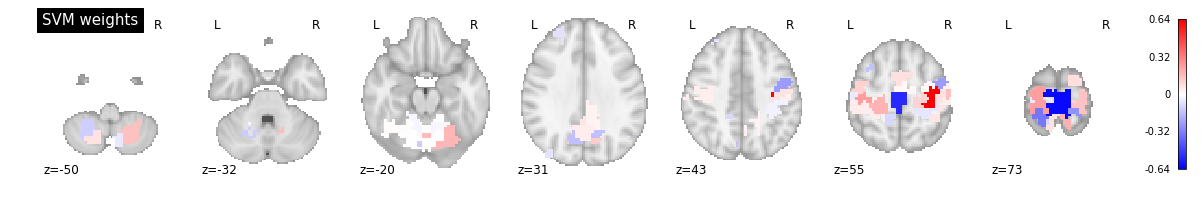

In [58]:
# Plot resulting weights of the SVM & selected regions
weights=pipeline_anova.named_steps['classif_name'].coef_

index=plot_selectedregions(pipeline_anova,masker,weights=weights,anova_name='anova')
weights_tr = pipeline_anova.named_steps['anova'].inverse_transform(weights)

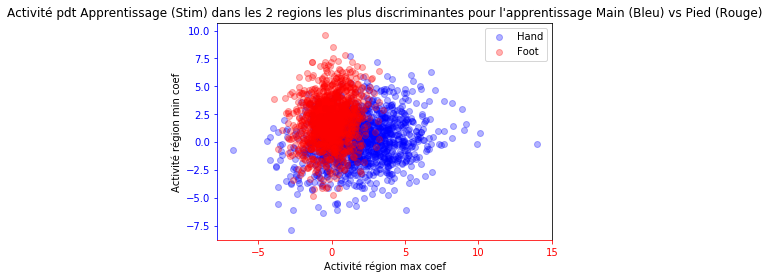

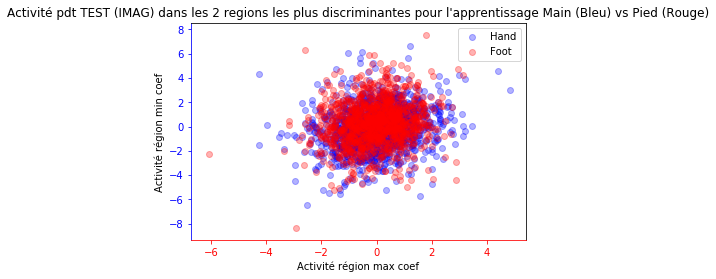

In [63]:
import matplotlib.pyplot as plt

amax_H=roi_train[y_train==b'hand',weights_tr.argmax()]
amax_F=roi_train[y_train==b'foot',weights_tr.argmax()]
amin_H=roi_train[y_train==b'hand',weights_tr.argmin()]
amin_F=roi_train[y_train==b'foot',weights_tr.argmin()]
fig=plt.figure()
ax=plt.subplot(1,1,1)
ax.scatter(amax_H,amin_H,c='b',alpha=0.3,label='Hand')
ax.scatter(amax_F,amin_F,c='r',alpha=0.3,label='Foot')

plt.xlabel('Activité région max coef')
plt.ylabel('Activité région min coef')
ax.spines['bottom'].set_color('r')
ax.spines['left'].set_color('b')
ax.tick_params(axis='x', colors='r')
ax.tick_params(axis='y', colors='b')
plt.legend()
plt.title("Activité pdt Apprentissage (Stim) dans les 2 regions les plus discriminantes pour l'apprentissage Main (Bleu) vs Pied (Rouge)")


amax_H=roi_test[y_train==b'hand',weights_tr.argmax()]
amax_F=roi_test[y_train==b'foot',weights_tr.argmax()]
amin_H=roi_test[y_train==b'hand',weights_tr.argmin()]
amin_F=roi_test[y_train==b'foot',weights_tr.argmin()]
fig=plt.figure()
ax=plt.subplot(1,1,1)
ax.scatter(amax_H,amin_H,c='b',alpha=0.3,label='Hand')
ax.scatter(amax_F,amin_F,c='r',alpha=0.3,label='Foot')

plt.xlabel('Activité région max coef')
plt.ylabel('Activité région min coef')
ax.spines['bottom'].set_color('r')
ax.spines['left'].set_color('b')
ax.tick_params(axis='x', colors='r')
ax.tick_params(axis='y', colors='b')
plt.legend()
plt.title("Activité pdt TEST (IMAG) dans les 2 regions les plus discriminantes pour l'apprentissage Main (Bleu) vs Pied (Rouge)")

### Test du niveau de chance (en gardant la structure de bloc)

In [10]:
### Permutation block
nb_p=1000
null_result=np.zeros(nb_p)
nb_s=len(names)
ncond=['hand','foot']
for i in range(nb_p):
    y_train_random=np.zeros((0,1),dtype='S12')
    # shuffle block number
    for suj in range(nb_s):
        xncond=np.random.permutation(ncond)
        suj_train_random=np.append(np.full(57,xncond[0],dtype='S12'),np.full(57,xncond[1],dtype='S12'))
        y_train_random=np.append(y_train_random,suj_train_random)

        
    pipeline_anova.fit(roi_train, y_train_random)
    prediction = pipeline_anova.predict(roi_test) 
    null_result[i]=accuracy_score(prediction,y_test)

sign=(null_result>=result).sum()/nb_p
print(sign)

0.001


Résultats: La classification imagination MAIN/PIED à partir de l'apprentissage de Stimulation MAIN/PIED donne des performances proches de 60 %, et vu le niveau de difficulté (cerveau entier, tache différente entre imagination et stimulation), c'est pas si mal (et largement significatif: p=0.001!)

Concernant les coefficients du SVM obtenus (c'est à dire les régions qui permettent la classification), on retrouve parfaitement les régions motrices de la main et du pied).

### Classification sur Stimulation seulement (de façon cross-validée)

In [15]:
cv = LeaveOneLabelOut(block)
score_cv = cross_val_score(pipeline_anova, roi_train, y_train,cv=cv)
print('STIM only CV',score_cv.mean())

STIM only CV 0.828403078403


## Apprentissage sur imagination; Test sur stimulation

Attention, vu que les taches diffèrent également au niveau visuel, la classification sur cerveau entier risque d'être faite sur le cortex visuel

In [6]:
pipeline_anova.fit(roi_test, y_test)
prediction = pipeline_anova.predict(roi_train)  
print('Accuracy:',accuracy_score(prediction,y_train)*100,'%')

Accuracy: 66.4673046252 %


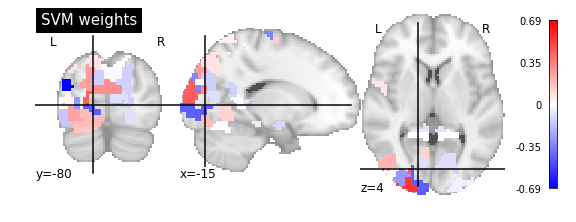

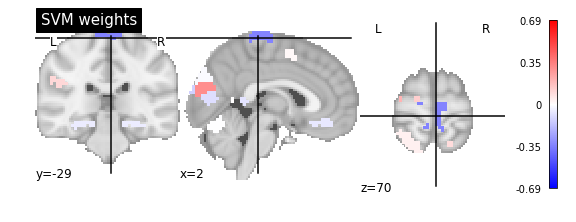

In [10]:
# Plot resulting weights of the SVM & selected regions
weights=pipeline_anova.named_steps['classif_name'].coef_
plot_selectedregions(pipeline_anova,masker,weights=weights,anova_name='anova')
plot_selectedregions(pipeline_anova,masker,weights=weights,anova_name='anova',cut_coords=[2,-29,70])

Résultats: La classification des données Stimulation MAIN/PIED donne de meilleures performances: 66 %, 
mais quand on regarde les coefficients du SVM obtenus (c'est à dire les régions qui permettent la classification),
on retrouve seulement les régions visuelles, donc probablement dues a des différences autres que motrices.
Etant donné la différence dans le conditions de l'input visuel, il est impossible d'interpreter ces poids.

## Analyse par sujets: 
Ne donne pas de bons résultats (classification significativement meilleure que la chance seulement chez 3 sujets.

## Apprentissage Stimulation sur tous les sujets - Test sur imagination par sujet

In [18]:
pipeline_anova.fit(roi_train, y_train)

result_i=np.zeros(nb_s)
for ni,n in enumerate(names):
    sim_filename=fold_g+'mni4060/roi_'+smt+'_'+n+'.npz'
    roi_i=np.load(sim_filename)['roi']
    roi_i=np.delete(roi_i,index_i,0)
    cond_i=roi_i[condition_mask_i]
    roi_test_i=cond_i[test_mask_i]
    #roi_train_i=cond_i[train_mask_i]# 
    prediction = pipeline_anova.predict(roi_test_i) 
    result_i[ni]=accuracy_score(prediction,y_test_i)
    print(n,'Accuracy:',result_i[ni]*100,'%')
    

ap Accuracy: 58.7719298246 %
as Accuracy: 55.2631578947 %
bh Accuracy: 64.0350877193 %
bi Accuracy: 57.0175438596 %
cmp Accuracy: 73.6842105263 %
cas Accuracy: 52.6315789474 %
cs Accuracy: 77.1929824561 %
cb Accuracy: 63.1578947368 %
gm Accuracy: 64.9122807018 %
gn Accuracy: 42.1052631579 %
gbn Accuracy: 57.8947368421 %
mv Accuracy: 63.1578947368 %
ms Accuracy: 69.298245614 %
pm Accuracy: 51.7543859649 %
pc Accuracy: 60.5263157895 %
ph Accuracy: 55.2631578947 %
pa Accuracy: 71.9298245614 %
pv Accuracy: 58.7719298246 %
pom Accuracy: 60.5263157895 %
rdc Accuracy: 59.649122807 %
ti Accuracy: 63.1578947368 %
vs Accuracy: 57.8947368421 %


### Test significativité

In [17]:
### Permutation block
nb_p=1000

null_result=np.zeros((nb_s,nb_p))

ncond=['hand','foot']
for i in range(nb_p):
    y_train_random=np.zeros((0,1),dtype='S12')
    # shuffle block number
    for suj in range(nb_s):
        xncond=np.random.permutation(ncond)
        suj_train_random=np.append(np.full(57,xncond[0],dtype='S12'),np.full(57,xncond[1],dtype='S12'))
        y_train_random=np.append(y_train_random,suj_train_random)
    pipeline_anova.fit(roi_train, y_train_random)
    for ni,n in enumerate(names):
        sim_filename=fold_g+'mni4060/roi_'+smt+'_'+n+'.npz'
        roi_i=np.load(sim_filename)['roi']
        roi_i=np.delete(roi_i,index_i,0)
        cond_i=roi_i[condition_mask_i]
        roi_test_i=cond_i[test_mask_i]
    #roi_train_i=cond_i[train_mask_i]# 
        prediction = pipeline_anova.predict(roi_test_i) 
        null_result[ni,i]=accuracy_score(prediction,y_test_i)


NameError: name 'result_i' is not defined

In [19]:
for ni,n in enumerate(names):
    sign=(null_result[ni]>=result_i[ni]).sum()/nb_p
    print(n,result_i[ni],sign)

ap 0.587719298246 0.084
as 0.552631578947 0.276
bh 0.640350877193 0.024
bi 0.570175438596 0.158
cmp 0.736842105263 0.002
cas 0.526315789474 0.376
cs 0.771929824561 0.0
cb 0.631578947368 0.041
gm 0.649122807018 0.048
gn 0.421052631579 0.856
gbn 0.578947368421 0.165
mv 0.631578947368 0.169
ms 0.69298245614 0.004
pm 0.517543859649 0.396
pc 0.605263157895 0.079
ph 0.552631578947 0.249
pa 0.719298245614 0.015
pv 0.587719298246 0.088
pom 0.605263157895 0.145
rdc 0.59649122807 0.17
ti 0.631578947368 0.024
vs 0.578947368421 0.173


Apprentissage Stim Hand/Foot sur tous les sujets, et test individuel Imag Hand/Foot :  8 Sujets avec classification p<0.05 . 11 supérieurs à 60%. BOF mais pas mal

### Classification seulement sur regions BASC motrices

In [27]:
#imag_region=np.fromfile('F:/IRM_Marche/harv_imag_basc444asym.np',dtype=int)

motor_region=np.fromfile('F:/IRM_Marche/harv_motorlarge_basc444asym.np',dtype=int)
#motor_region_index=np.fromfile('F:/IRM_Marche/motorregion57_basc444asym.np',dtype=int)
#motor_region_index=np.unique(np.hstack((imag_region,motor_region)))

motor_region_index=motor_region
print(motor_region_index,len(motor_region_index))

[ 16  20  22  28  30  35  38  53  66  67  68  70  80  86  89  91 104 108
 111 121 124 126 133 136 137 144 154 156 158 184 186 189 191 195 201 209
 214 219 230 237 238 239 251 257 260 266 277 279 281 284 287 303 310 316
 343 344 351 363 365 369 372 387 397 401 421 425 427 428 432 435] 70


In [72]:
result_i=np.zeros(nb_s)
pipeline = Pipeline([('scale', scaler),('classif_name', svm)])
for ni,n in enumerate(names):
    sim_filename=fold_g+'mni4060/asymroi_'+smt+'_'+n+'.npz'
    roi_i=np.load(sim_filename)['roi']
    roi_i=np.delete(roi_i,index_i,0)
    roi_m=roi_i[:,motor_region_index-1]
    cond_i=roi_m[condition_mask_i]
    roi_test_i=cond_i[test_mask_i]
    roi_train_i=cond_i[train_mask_i]# 
    pipeline.fit(roi_train_i, y_train_i)
    prediction = pipeline.predict(roi_test_i) 
    result_i[ni]=accuracy_score(prediction,y_test_i)
    print(n,'Accuracy:',result_i[ni]*100,'%')
print(result_i.mean())

ap Accuracy: 50.0 %
as Accuracy: 46.4912280702 %
bh Accuracy: 57.8947368421 %
bi Accuracy: 48.2456140351 %
cmp Accuracy: 72.8070175439 %
cas Accuracy: 57.8947368421 %
cs Accuracy: 64.9122807018 %
cb Accuracy: 51.7543859649 %
gm Accuracy: 57.0175438596 %
gn Accuracy: 51.7543859649 %
gbn Accuracy: 57.0175438596 %
mv Accuracy: 57.0175438596 %
ms Accuracy: 53.5087719298 %
pm Accuracy: 46.4912280702 %
pc Accuracy: 48.2456140351 %
ph Accuracy: 63.1578947368 %
pa Accuracy: 57.0175438596 %
pv Accuracy: 53.5087719298 %
pom Accuracy: 50.0 %
rdc Accuracy: 39.4736842105 %
ti Accuracy: 48.2456140351 %
vs Accuracy: 57.0175438596 %
0.540669856459


In [71]:
for ni,n in enumerate(names):
    sim_filename=fold_g+'mni4060/asymroi_'+smt+'_'+n+'.npz'
    roi_i=np.load(sim_filename)['roi']
    roi_i=np.delete(roi_i,index_i,0)
    roi_m=roi_i[:,motor_region_index-1]
    cond_i=roi_m[condition_mask_i]
    roi_test_i=cond_i[test_mask_i]
    roi_train_i=cond_i[train_mask_i]# 
    pipeline.fit(roi_test_i, y_test_i)
    prediction = pipeline.predict(roi_train_i) 
    result_i[ni]=accuracy_score(prediction,y_train_i)
    print(n,'Accuracy:',result_i[ni]*100,'%')
print(result_i.mean())

ap Accuracy: 57.0175438596 %
as Accuracy: 58.7719298246 %
bh Accuracy: 57.8947368421 %
bi Accuracy: 44.7368421053 %
cmp Accuracy: 72.8070175439 %
cas Accuracy: 32.4561403509 %
cs Accuracy: 79.8245614035 %
cb Accuracy: 55.2631578947 %
gm Accuracy: 56.1403508772 %
gn Accuracy: 39.4736842105 %
gbn Accuracy: 65.7894736842 %
mv Accuracy: 75.4385964912 %
ms Accuracy: 72.8070175439 %
pm Accuracy: 31.5789473684 %
pc Accuracy: 49.1228070175 %
ph Accuracy: 47.3684210526 %
pa Accuracy: 72.8070175439 %
pv Accuracy: 52.6315789474 %
pom Accuracy: 67.5438596491 %
rdc Accuracy: 33.3333333333 %
ti Accuracy: 41.2280701754 %
vs Accuracy: 67.5438596491 %
0.55980861244


In [75]:

k=50 #best 52
feature_selection = SelectKBest(f_classif, k=k)
pipeline_anova = Pipeline([('anova', feature_selection), ('scale', scaler),('classif_name', svm)])

pipeline = Pipeline([('scale', scaler),('classif_name', svm)])
roi_m_test=roi_test[:,motor_region_index-1]
roi_m_train=roi_train[:,motor_region_index-1]
pipeline.fit(roi_m_test, y_test)
coef_imag = pipeline.named_steps['classif_name'].coef_
#coef_imag = pipeline_anova.named_steps['anova'].inverse_transform(coef_imag)
prediction = pipeline.predict(roi_m_train)  
print('Accuracy Train:IMAG Test: STIM:',accuracy_score(prediction,y_train)*100,'%')

pipeline.fit(roi_m_train, y_train)

prediction = pipeline.predict(roi_m_test)  
coef_imp = pipeline.named_steps['classif_name'].coef_
#coef_imp = pipeline_anova.named_steps['anova'].inverse_transform(coef_imp)
print('Accuracy Train:STIM Test:IMAG:',accuracy_score(prediction,y_test)*100,'%')

Accuracy Train:IMAG Test: STIM: 73.4449760766 %
Accuracy Train:STIM Test:IMAG: 57.9346092504 %


    - Train Stim 0.004 (**)
    - Train Imag 0.008 (**)

In [66]:
cv = LeaveOneLabelOut(block)
score_cv = cross_val_score(pipeline, roi_m_train, y_train,cv=cv)
print('STIM only CV',score_cv.mean())
score_cv = cross_val_score(pipeline, roi_m_test, y_train,cv=cv)
print('IMAG only CV',score_cv.mean())

STIM only CV 0.82196969697
IMAG only CV 0.659090909091


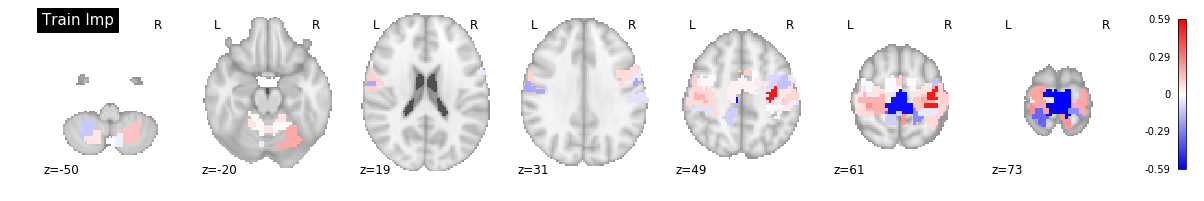

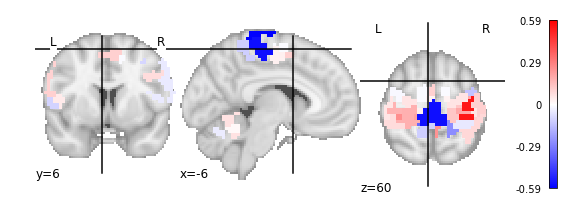

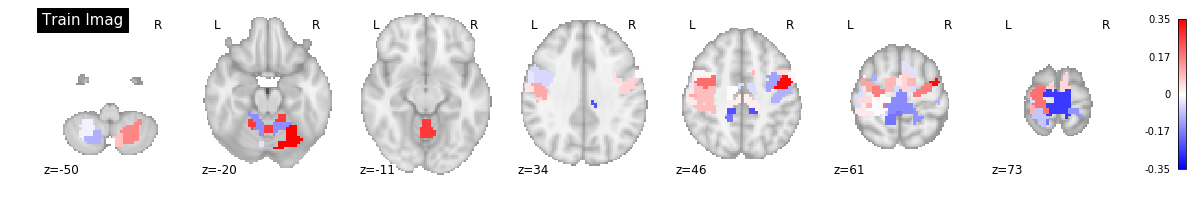

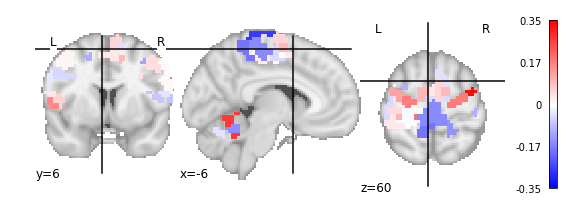

In [65]:
# Plot resulting weights of the SVM & selected regions


coef_tr_imp=np.zeros([1,444])
coef_tr_imag=np.zeros([1,444])
for i,n in enumerate(motor_region_index):
    coef_tr_imp[0,n-1]=coef_imp[0,i]
    coef_tr_imag[0,n-1]=coef_imag[0,i]
from nilearn.plotting import plot_stat_map
weight_img_trimp = masker.inverse_transform(coef_tr_imp)
weight_img_trimag = masker.inverse_transform(coef_tr_imag)
plot_stat_map(weight_img_trimp, title='Train Imp',display_mode='z',cmap='bwr')
plot_stat_map(weight_img_trimp,cmap='bwr', cut_coords=[-6, 6, 60])

plot_stat_map(weight_img_trimag, title='Train Imag',display_mode='z',cmap='bwr')
plot_stat_map(weight_img_trimag,cmap='bwr', cut_coords=[-6, 6, 60])

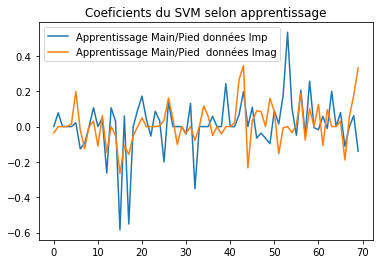

In [67]:
import matplotlib.pyplot as plt
plt.plot(coef_imp.T,label='Apprentissage Main/Pied données Imp')
plt.plot(coef_imag.T,label='Apprentissage Main/Pied  données Imag')
plt.title('Coeficients du SVM selon apprentissage')
plt.legend()

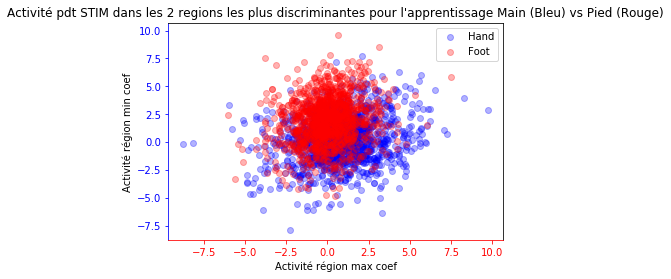

In [73]:
import matplotlib.pyplot as plt
amax_H=roi_m_train[y_train==b'hand',coef_imag.argmax()]
amax_F=roi_m_train[y_train==b'foot',coef_imag.argmax()]
amin_H=roi_m_train[y_train==b'hand',coef_imag.argmin()]
amin_F=roi_m_train[y_train==b'foot',coef_imag.argmin()]
fig=plt.figure()
ax=plt.subplot(1,1,1)
ax.scatter(amax_H,amin_H,c='b',alpha=0.3,label='Hand')
ax.scatter(amax_F,amin_F,c='r',alpha=0.3,label='Foot')

plt.xlabel('Activité région max coef')
plt.ylabel('Activité région min coef')
ax.spines['bottom'].set_color('r')
ax.spines['left'].set_color('b')
ax.tick_params(axis='x', colors='r')
ax.tick_params(axis='y', colors='b')
plt.legend()
#plt.xlim(-10,10)
#plt.ylim(-15,15)
plt.title("Activité pdt STIM dans les 2 regions les plus discriminantes pour l'apprentissage Main (Bleu) vs Pied (Rouge)")

In [37]:
roi_m_train.shape

(2508, 70)

(array([  10.,   36.,  109.,  249.,  338.,  307.,  134.,   55.,   14.,    2.]),
 array([-4.80654508, -3.36833042, -1.93011575, -0.49190109,  0.94631358,
         2.38452824,  3.8227429 ,  5.26095757,  6.69917223,  8.1373869 ,
         9.57560156]),
 <a list of 10 Patch objects>)

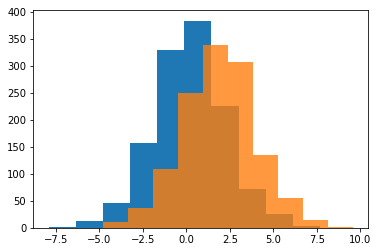

In [78]:
plt.hist(amin_H)
plt.hist(amin_F,alpha=0.8)

In [84]:
### Permutation block
pipeline.fit(roi_m_train, y_train)
prediction = pipeline.predict(roi_m_test)  
result_tr_stim=accuracy_score(prediction,y_test)

pipeline.fit(roi_m_test, y_test)
prediction = pipeline.predict(roi_m_train)  
result_tr_imag=accuracy_score(prediction,y_train)

nb_p=1000
null_result_tr_stim=np.zeros(nb_p)
null_result_tr_imag=np.zeros(nb_p)
nb_s=len(names)
ncond=['foot','hand']
for i in range(nb_p):
    y_train_random=np.zeros((0,1),dtype='S12')
    # shuffle block number
    for suj in range(nb_s):
        xncond=np.random.permutation(ncond)
        suj_train_random=np.append(np.full(57,xncond[0],dtype='S12'),np.full(57,xncond[1],dtype='S12'))
        y_train_random=np.append(y_train_random,suj_train_random)

        
    pipeline.fit(roi_m_train, y_train_random)
    prediction = pipeline.predict(roi_m_test) 
    null_result_tr_stim[i]=accuracy_score(prediction,y_test)
    
    pipeline.fit(roi_m_test, y_train_random)
    prediction = pipeline.predict(roi_m_train) 
    null_result_tr_imag[i]=accuracy_score(prediction,y_train)

sign_tr_stim=(null_result_tr_stim>=result_tr_stim).sum()/nb_p
sign_tr_imag=(null_result_tr_imag>=result_tr_imag).sum()/nb_p
print('Train Stim',sign_tr_stim,'Train Imag',sign_tr_imag,)

Train Stim 0.004 Train Imag 0.008


In [83]:
y_train

array([b'foot', b'foot', b'foot', ..., b'hand', b'hand', b'hand'], 
      dtype='|S32')